Importando bibliotecas necessárias:

In [2]:
import os
import re
import glob
import random
import math

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from tqdm.notebook import tqdm

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


---
---
## Defina seus paths:

In [5]:
ROOT =  "/content/drive/MyDrive/ep_data"
assert os.path.exists(ROOT), "ROOT doest not exist"

DATASET_GRAY = os.path.join(ROOT, 'dataset_gray')
assert os.path.exists(DATASET_GRAY), "DATASET_GRAY doest not exist"

DATASET_AUGMENTED = os.path.join(ROOT, 'dataset_gray')
assert os.path.exists(DATASET_AUGMENTED), "DATASET_AUGMENTED doest not exist"

PATH_DATASET_GROUND = os.path.join(ROOT, "dataset_ground_truth")

---
---
# Utils

In [6]:
def plot(im, title=None):
    if isinstance(im, str):
        im = cv2.imread(im, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(5,5))
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

In [7]:
def get_gray_image(file=None):
    images = glob.glob(os.path.join(DATASET_GRAY, '*', '*.png'))
    test_image = random.choice(images)
    print("Got " + test_image)
    if file:
        test_image = file
    test_im = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)
    return test_im

In [8]:
def get_images_dict(path):
  images = {}
  for dirpath, dirname, filename in os.walk(path):
      object_class = dirpath.split("/")[-1]
      for f in tqdm(filename, desc=f"{object_class}  -> "):
              if f.split(".")[-1] in ["jpg", "png", "jpeg"]:
                  path = os.path.join(dirpath, f)
                  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                  images[f] = img
  return images

In [9]:
from skimage.draw import rectangle
class BoundingBox(object):
  """ Bounding box class
  """
  def __init__(self):
    
    self.min_x, self.max_x = None, None
    self.min_y, self.max_y = None, None
    self.shape = None
  
  def update(self, image):
    """ Extract bounding box for binary image
    """
    
    coordinates = np.argwhere(image.astype("bool") == 1)  
    #min_x, max_x, min_y, max_y = 255, 0, 255, 0
    #for coord in coordinates:
    self.min_y, self.min_x = coordinates.min(axis = 0)
    self.max_y, self.max_x = coordinates.max(axis = 0)
    self.shape = image.shape

  def get_bbox_image(self):
    if self.shape != None:
      rows, cols = rectangle(start = (self.min_y, self.min_x), 
                            end = (self.max_y, self.max_x), 
                            shape = self.shape)
      bbox_image = np.zeros(self.shape).astype("bool")
      bbox_image[rows, cols] = True
      return bbox_image
    else:
      return None

  def get_area(self):
    return (self.max_y - self.min_y)*(self.max_x - self.min_x)

  def draw_bbox_border(self, color = "red", fill = False):
    """ Returns a matplotlib rectangle for drawing
    """
    plt_rect = mpatches.Rectangle((self.min_x, self.min_y), 
                                  self.max_x - self.min_x, 
                                  self.max_y - self.min_y,
                                  fill = fill, edgecolor = color, 
                                  linewidth=2)
    
    return plt_rect

## Binarization methods

In [10]:
def segment_global_otsu(im, blur=True):
    img = im.copy()
    if blur:
        img = cv2.GaussianBlur(img, (5,5), 0)
    _, mask = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return mask

In [11]:
def segment_adaptive_gaussian(im, blur=True):
    img = im.copy()
    if blur:
        img = cv2.GaussianBlur(img, (5,5), 0)
    th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY, 21, 1)
    return th3

In [12]:
def canny(im, t1=150, t2=200):
    return cv2.Canny(im, t1, t2)

## AUXILIAR

In [13]:
def opening(im, kernel_shape=(3,3)):
    img = im.copy()
    kernel = np.ones(kernel_shape, np.uint8)
    th3 = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return th3

def closing(im, kernel_shape=(3,3)):
    img = im.copy()
    kernel = np.ones(kernel_shape, np.uint8)
    th3 = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)
    return th3

def gaussian_2d_filter(shape, mu, sigma):
    x, y = np.meshgrid(np.linspace(-1, 1, shape[0]), np.linspace(-1, 1, shape[1]))
    d = np.sqrt(x**2 + y**2)
    return np.exp(
        -np.power(d, 2.)/(2 * np.power(sigma, 2.))
    )

---
---
# Watershed

Etapas:
- equalização do histograma;
- filtro blur bilateral;
- aguçamento da imagem;
- binarização da imagem;
- definição das sementes;
- aplicação do algoritmo

In [14]:
def segment_watershed(image_in, verbose=False):
    im = image_in.copy()
    H, W = im.shape

    # 1. Increase contrast with CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    im_clahe = clahe.apply(im)
    if verbose: plot(im_clahe, "CLAHE: equalization")
    
    im_clahe = cv2.bilateralFilter(im_clahe, 9, 100, 100)
    if verbose: plot(im_clahe, "Bilateral filter")
    
    # 2. Sharpen the edges
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32) # Laplacian
    imgLaplacian = cv2.filter2D(im_clahe, cv2.CV_32F, kernel)
    
    sharp = np.float32(im_clahe)
    imgResult = sharp - imgLaplacian

    #### convert back to 8bits gray scale
    imgResult = np.clip(imgResult, 0, 255)
    imgResult = imgResult.astype('uint8')
    imgLaplacian = np.clip(imgLaplacian, 0, 255)
    imgLaplacian = np.uint8(imgLaplacian)
    if verbose:
        plot(imgResult, "Sharpened")

    # 3. Binarize
    #### Mean of gray levels in the whole image
    intensity_mean = np.mean(im_clahe)
    # print("Whole intensity mean: ", intensity_mean)

    ##### Mean of gray levels in the edge of the image
    outer_mask = np.ones(im.shape).astype(np.uint8)
    outer_mask[int(0.2*H):-int(0.2*H),int(0.2*W):-int(0.2*W)] = 0
    outer_intensity_mean = cv2.mean(im_clahe, mask=outer_mask)[0]
    # print("Outer intensity: ", outer_intensity_mean)

    binary = segment_global_otsu(imgResult, blur=True)

    ##### The background is darker than foreground?
    if outer_intensity_mean > intensity_mean:
    # if np.sum(binary > 0) > 0.5 * H * W:
        binary = 255 - binary

    if verbose: plot(binary, "Binarized")

    nb_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)

#     plot(labels, "CONNECTED COMPONENTS")
        
    # 4. noise removal
    kernel = np.ones((5,5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations = 1)
    if verbose: plot(binary, "Binarized: opened")
        
    
    # 5. watershed
    sure_bg = cv2.dilate(binary, kernel, iterations=3)
    
    ###### Finding sure foreground area
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

    size = 60
    dist_transform[:size] = 0
    dist_transform[-size:] = 0
    dist_transform[:, :size] = 0
    dist_transform[:, -size:] = 0

    if verbose: plot(dist_transform, "Distance transform")
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    if verbose: plot(sure_fg, "Sure FG")

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv2.watershed(cv2.cvtColor(cv2.GaussianBlur(imgResult,(7,7),0), cv2.COLOR_GRAY2BGR),markers)
    im[markers == -1] = 255
    if verbose: plot(markers, 'Markers')

    final = np.zeros_like(markers)
    for i in np.unique(markers):
        if i in [ 1]:
            continue
        final += markers == i

    # Remove disconnected pieces
    nb_label, label = cv2.connectedComponents(final.astype(np.uint8))
    if nb_label > 2:
        greater_label = 1
        area = np.sum(label == 1)
        for i in range(2, nb_label):
            if np.sum(label == i) > area:
                area = np.sum(label == i)
                greater_label = i
        final = np.zeros_like(final)
        final += (label == greater_label)


    final = final.astype(np.uint8)
    final = closing(final, (5,5))
    if verbose: plot(final, "Result")
    if verbose:
        bbox = BoundingBox()
        bbox.update(final)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(image_in, cmap = "gray")
        ax.set_title("Original with bbox")
        ax.set_axis_off()
        bbox = BoundingBox()
        bbox.update(final)
        ax.add_patch(bbox.draw_bbox_border())
    return final

Got /content/drive/MyDrive/ep_data/dataset_gray/livro/livro_obj4_p2_di_f1.png


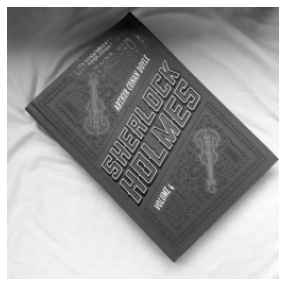

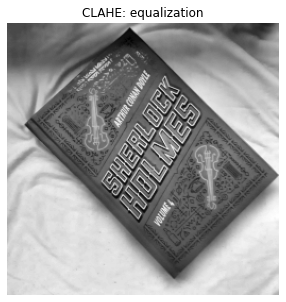

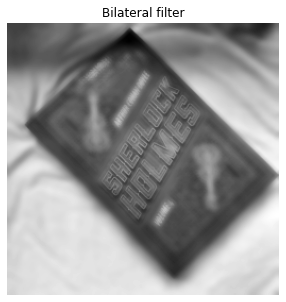

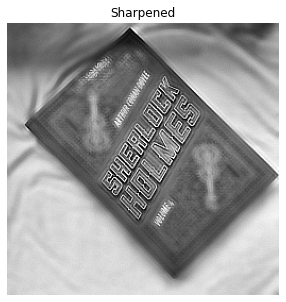

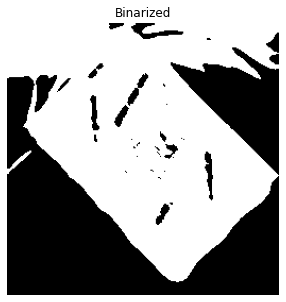

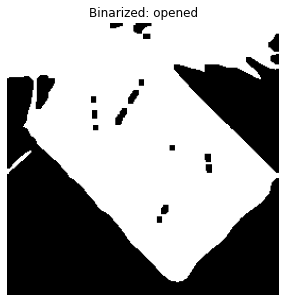

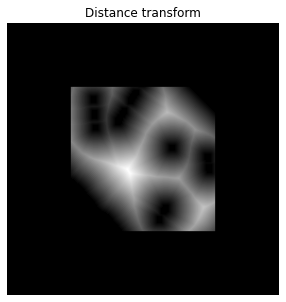

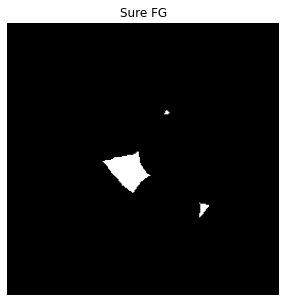

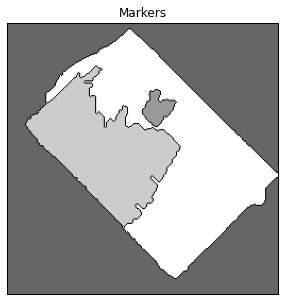

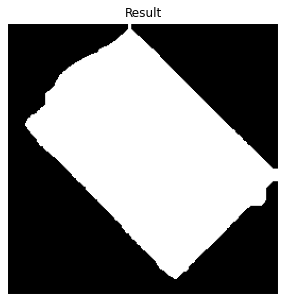

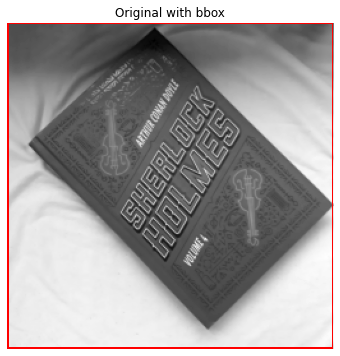

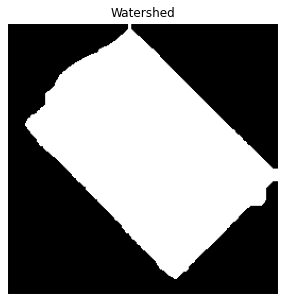

In [35]:
im = get_gray_image(); plot(im)
segmented = segment_watershed(im, True)
plot(segmented, "Watershed")

# Avaliação da segmentação

## Funcões auxiliares para os cálculos de métrica

- Função para apresentar a tabela com as métricas

In [16]:
from tabulate import tabulate

classNames = ["tesoura", "garrafa", "chave", "prato", "livro", "sapato", "chinelo", "celular", "portacopo", "caneca"]
def print_metric_table(metric_dict, return_table = False):
  """ Prints a table stratitying the average of the metric stratified by object
  and light

  Parameters
  ----------
  metric_dict: built-in dict
  The keys must be the image name, the values are the metric value for that 
  image


  """
  ### Setup dictionaries
  #--
  light_names = ["de", "di", "ne", "ni"]
  table_dict_obj = {}
  table_dict_light = {}
  total = []
  for light in light_names:
    table_dict_light[light] = []
  for obj_class in classNames:
    table_dict_obj[obj_class] = []    
  table_dict = {}
  for obj_class in classNames:
    table_dict[obj_class] = {}
    for light in light_names:
      table_dict[obj_class][light] = []
  #--

  ### Fill dictionaries
  #--
  for key in metric_dict.keys():
    obj_class, _, _, light, _ = key.split("_")
    metric_value = metric_dict[key]
    table_dict[obj_class][light].append(metric_value)
    table_dict_obj[obj_class].append(metric_value)
    table_dict_light[light].append(metric_value)
    total.append(metric_value)
  #--


  ### Creates table
  def compute_mean(score):
    if len(score) == 0:
      return np.NAN
    else:
      return round(np.mean(score), 3)

  table = [["Obj", "de", "di", "ne", "ni", "TOTAL"]]
  for obj_class in classNames:
    row = [obj_class]
    for light in light_names:
      row.append(compute_mean(table_dict[obj_class][light]))
    row.append(compute_mean(table_dict_obj[obj_class]))

    table.append(row)
  row = ["TOTAL"]
  for light in light_names:
    row.append(compute_mean(table_dict_light[light]))
  row.append(compute_mean(total))
  table.append(row)
  print(tabulate(table))
  if return_table:
    return table

In [26]:
def print_metric_table_fundo(metric_dict, return_table = False):
  """ Prints a table stratitying the average of the metric stratified by object
  and light

  Parameters
  ----------
  metric_dict: built-in dict
  The keys must be the image name, the values are the metric value for that 
  image


  """
  ### Setup dictionaries
  #--
  light_names = ["f1", "f2", "f3"]
  table_dict_obj = {}
  table_dict_light = {}
  total = []
  for light in light_names:
    table_dict_light[light] = []
  for obj_class in classNames:
    table_dict_obj[obj_class] = []    
  table_dict = {}
  for obj_class in classNames:
    table_dict[obj_class] = {}
    for light in light_names:
      table_dict[obj_class][light] = []
  #--

  ### Fill dictionaries
  #--
  for key in metric_dict.keys():
    obj_class, _, _, _, light = key.split("_")
    light = light.split('.')[0]
    metric_value = metric_dict[key]
    table_dict[obj_class][light].append(metric_value)
    table_dict_obj[obj_class].append(metric_value)
    table_dict_light[light].append(metric_value)
    total.append(metric_value)
  #--


  ### Creates table
  def compute_mean(score):
    if len(score) == 0:
      return np.NAN
    else:
      return round(np.mean(score), 3)

  table = [["Obj", "f1", "f2", "f3", "TOTAL"]]
  for obj_class in classNames:
    row = [obj_class]
    for light in light_names:
      row.append(compute_mean(table_dict[obj_class][light]))
    row.append(compute_mean(table_dict_obj[obj_class]))

    table.append(row)
  row = ["TOTAL"]
  for light in light_names:
    row.append(compute_mean(table_dict_light[light]))
  row.append(compute_mean(total))
  table.append(row)
  print(tabulate(table))
  if return_table:
    return table

- Função para cálculo de Jaccard e Dice

In [17]:
def fast_jaccard(bbox1, bbox2):
  """ Computes jaccard index without requiring the images
  """

  bbox_inter = BoundingBox()
  bbox_inter.min_x = max(bbox1.min_x, bbox2.min_x)
  bbox_inter.min_y = max(bbox1.min_y, bbox2.min_y)
  bbox_inter.max_x = min(bbox1.max_x, bbox2.max_x)
  bbox_inter.max_y = min(bbox1.max_y, bbox2.max_y)
  area_intersection = bbox_inter.get_area()
  area_union = bbox1.get_area() + bbox2.get_area() - area_intersection
  return area_intersection/area_union

def fast_dice(bbox1, bbox2):
  """ Computes the dice score without requiring the images
  """

  bbox_inter = BoundingBox()
  bbox_inter.min_x = max(bbox1.min_x, bbox2.min_x)
  bbox_inter.min_y = max(bbox1.min_y, bbox2.min_y)
  bbox_inter.max_x = min(bbox1.max_x, bbox2.max_x)
  bbox_inter.max_y = min(bbox1.max_y, bbox2.max_y)
  area_intersection = bbox_inter.get_area()
  sum_of_areas = bbox1.get_area() + bbox2.get_area()
  return (2*area_intersection)/sum_of_areas


def evaluate_bbox(image_true, image_pred, 
                  metric = "jaccard", plot_comparison = False):
  """ Evaluates the bouding boxes using jaccard index
  """
  bbox_true = BoundingBox()
  bbox_true.update(image_true)
  bbox_pred = BoundingBox()
  bbox_pred.update(image_pred)
  if metric == "jaccard":
    metric_value = fast_jaccard(bbox_true, bbox_pred)
  elif metric == "dice":
    metric_value = fast_dice(bbox_true, bbox_pred)
  else:
    raise f"Error! Metric {metric} not implemented"
  if plot_comparison:
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.imshow(image_true, cmap = "gray")
    ax.set_title(f"Green: True bbox - Red: Predicted bbox - {metric}: {round(metric_value, 3)}")
    ax.set_axis_off()
    ax.add_patch(bbox_true.draw_bbox_border(color = "green"))
    ax.add_patch(bbox_pred.draw_bbox_border(color = "red"))
    plt.show()
  return metric_value

In [18]:
def compute_jaccard(img1, img2):
  """ Computes jaccard index on images
  """

  area_union = np.sum(np.logical_or(img1, img2))
  area_intersection = np.sum(np.logical_and(img1, img2))
  return area_intersection/area_union

def compute_dice(img1, img2):
  """ Computes the dice score on images
  """

  area_img1 = np.sum(img1.astype("bool"))
  area_img2 = np.sum(img2.astype("bool"))
  area_intersection = np.sum(np.logical_and(img1, img2))
  sum_of_areas = area_img1 + area_img2
  return (2*area_intersection)/sum_of_areas


def evaluate_segmentation(image_true, image_pred, 
                          metric = "jaccard", plot_comparison = False):
  """ Evaluates the bouding boxes using jaccard index
  """
  if metric == "jaccard":
    metric_value = compute_jaccard(image_true, image_pred)
  elif metric == "dice":
    metric_value = compute_dice(image_true, image_pred)
  else:
    raise f"Error! Metric {metric} not implemented"
  if plot_comparison:
    fig, ax = plt.subplots(1, 2, figsize=(5, 3))
    ax[0].imshow(image_true, cmap = "gray")
    ax[0].set_title(f"True")
    ax[0].set_axis_off()
    ax[1].imshow(image_pred, cmap = "gray")
    ax[1].set_title(f"Predicted - {metric}: {metric_value}")
    ax[1].set_axis_off()    
    plt.show()
  return metric_value

## Calculando ...

In [19]:
groundTruthImagesDict = get_images_dict(PATH_DATASET_GROUND)

dataset_ground_truth  -> : 0it [00:00, ?it/s]

garrafa  -> :   0%|          | 0/22 [00:00<?, ?it/s]

portacopo  -> :   0%|          | 0/22 [00:00<?, ?it/s]

prato  -> :   0%|          | 0/21 [00:00<?, ?it/s]

caneca  -> :   0%|          | 0/27 [00:00<?, ?it/s]

livro  -> :   0%|          | 0/27 [00:00<?, ?it/s]

sapato  -> :   0%|          | 0/26 [00:00<?, ?it/s]

celular  -> :   0%|          | 0/24 [00:00<?, ?it/s]

chinelo  -> :   0%|          | 0/24 [00:00<?, ?it/s]

tesoura  -> :   0%|          | 0/21 [00:00<?, ?it/s]

chave  -> :   0%|          | 0/22 [00:00<?, ?it/s]

In [20]:
grayImagesDict = get_images_dict(DATASET_GRAY)

dataset_gray  -> : 0it [00:00, ?it/s]

celular  -> :   0%|          | 0/180 [00:00<?, ?it/s]

sapato  -> :   0%|          | 0/216 [00:00<?, ?it/s]

chinelo  -> :   0%|          | 0/144 [00:00<?, ?it/s]

caneca  -> :   0%|          | 0/144 [00:00<?, ?it/s]

tesoura  -> :   0%|          | 0/144 [00:00<?, ?it/s]

livro  -> :   0%|          | 0/144 [00:00<?, ?it/s]

portacopo  -> :   0%|          | 0/144 [00:00<?, ?it/s]

garrafa  -> :   0%|          | 0/144 [00:00<?, ?it/s]

prato  -> :   0%|          | 0/144 [00:00<?, ?it/s]

chave  -> :   0%|          | 0/144 [00:00<?, ?it/s]

In [21]:
def getOriginalGroundTruthDict(imagesDict, groundTruthImageDict):
  images = {}
  for key in groundTruthImageDict.keys():
    filename = re.sub("_[a-zA-Z]+\.png", ".png", key)
    if filename in imagesDict:
      images[filename] = imagesDict[filename]
  return images

originalGroundTruthImagesDict = getOriginalGroundTruthDict(grayImagesDict, groundTruthImagesDict)
# originalGroundTruthImagesList = list(originalGroundTruthImagesDict.values())

### Jaccard - segmentation

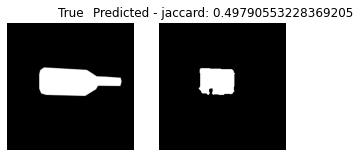

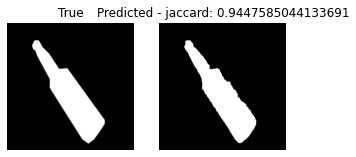

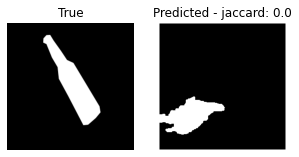

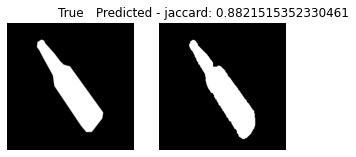

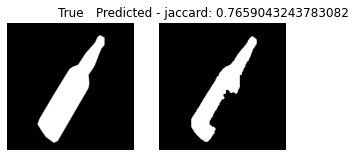

Average Jaccard Index: 0.4706713324085389
---------  -----  -----  -----  -----  -----
Obj        de     di     ne     ni     TOTAL
tesoura    0.003  0.179  0.129  0.29   0.144
garrafa    0.616  0.224  0.172  0.662  0.394
chave      0.485  0.511  0.039  0.483  0.45
prato      0.592  0.614  0.446  0.646  0.599
livro      0.635  0.772  0.417  0.549  0.603
sapato     0.377  0.498  0.228  0.439  0.426
chinelo    0.616  0.675  0.467  0.521  0.561
celular    0.531  0.695  0.208  0.598  0.533
portacopo  0.113  0.326  0.386  0.382  0.326
caneca     0.51   0.764  0.394  0.608  0.596
TOTAL      0.481  0.545  0.307  0.512  0.471
---------  -----  -----  -----  -----  -----
---------  -----  -----  -----  -----
Obj        f1     f2     f3     TOTAL
tesoura    0.125  0.185  0.112  0.144
garrafa    0.671  0.289  0.292  0.394
chave      0.474  0.413  0.45   0.45
prato      0.349  0.966  0.443  0.599
livro      0.497  0.738  0.543  0.603
sapato     0.456  0.413  0.418  0.426
chinelo    0.761  0.687  0

In [39]:
avg_jaccard = 0
n_imgs = 0
jaccard_dict_seg = {}
for key in groundTruthImagesDict.keys():
  image_gt = groundTruthImagesDict[key]
  image_seg = segment_watershed(originalGroundTruthImagesDict[key])
#   image_with_interior = fill_segmentation_interior(image_seg)
  jaccard_dict_seg[key] = evaluate_segmentation(image_gt, image_seg, 
                                            metric = "jaccard",
                                            plot_comparison = (n_imgs < 5) )
  avg_jaccard += jaccard_dict_seg[key] 
  n_imgs += 1
print(f"Average Jaccard Index: {avg_jaccard/n_imgs}")
print_metric_table(jaccard_dict_seg)
print_metric_table_fundo(jaccard_dict_seg)

### Dice - segmentation

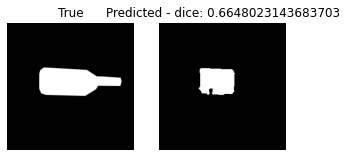

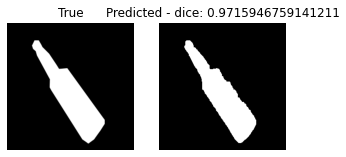

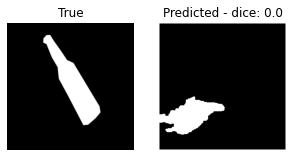

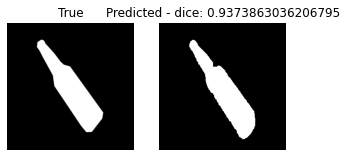

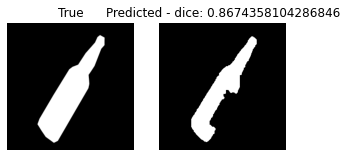

Average Jaccard Index: 0.5634607528732768
---------  -----  -----  -----  -----  -----
Obj        de     di     ne     ni     TOTAL
tesoura    0.006  0.224  0.154  0.418  0.189
garrafa    0.741  0.325  0.252  0.782  0.498
chave      0.574  0.552  0.076  0.529  0.509
prato      0.698  0.712  0.613  0.755  0.709
livro      0.739  0.845  0.521  0.625  0.693
sapato     0.507  0.624  0.341  0.584  0.555
chinelo    0.727  0.762  0.604  0.605  0.671
celular    0.625  0.788  0.325  0.629  0.623
portacopo  0.197  0.399  0.483  0.435  0.4
caneca     0.621  0.85   0.511  0.735  0.702
TOTAL      0.577  0.631  0.405  0.602  0.563
---------  -----  -----  -----  -----  -----
---------  -----  -----  -----  -----
Obj        f1     f2     f3     TOTAL
tesoura    0.144  0.24   0.174  0.189
garrafa    0.778  0.412  0.374  0.498
chave      0.518  0.486  0.519  0.509
prato      0.501  0.983  0.601  0.709
livro      0.597  0.79   0.662  0.693
sapato     0.584  0.541  0.549  0.555
chinelo    0.841  0.804  0

In [38]:
avg_dice = 0
n_imgs = 0
dice_dict_seg = {}
for key in groundTruthImagesDict.keys():
  image_gt = groundTruthImagesDict[key]
  image_seg = segment_watershed(originalGroundTruthImagesDict[key])
#   image_with_interior = fill_segmentation_interior(image_seg)
  dice_dict_seg[key] = evaluate_segmentation(image_gt, image_seg, 
                                            metric = "dice",
                                            plot_comparison = (n_imgs < 5) )
  avg_dice += dice_dict_seg[key] 
  n_imgs += 1
print(f"Average Jaccard Index: {avg_dice/n_imgs}")
print_metric_table(dice_dict_seg)
print_metric_table_fundo(dice_dict_seg)

### Jaccard - bbox

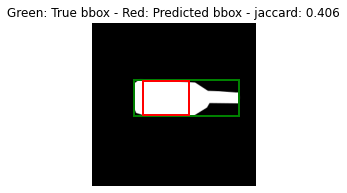

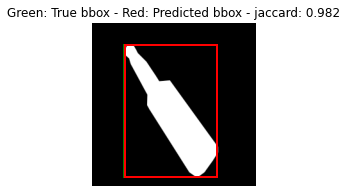

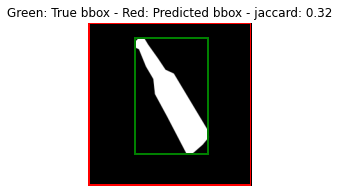

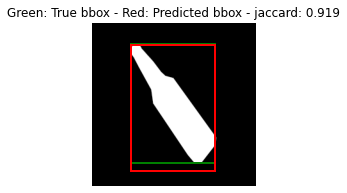

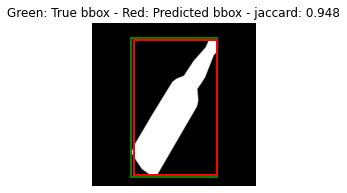

Average Jaccard Index: 0.5454217683618916
---------  -----  -----  -----  -----  -----
Obj        de     di     ne     ni     TOTAL
tesoura    0.061  0.148  0.116  0.356  0.158
garrafa    0.678  0.291  0.261  0.609  0.445
chave      0.456  0.502  0.118  0.5    0.45
prato      0.699  0.595  0.49   0.642  0.626
livro      0.663  0.872  0.563  0.713  0.708
sapato     0.713  0.656  0.375  0.765  0.643
chinelo    0.823  0.713  0.48   0.604  0.626
celular    0.688  0.711  0.497  0.725  0.668
portacopo  0.113  0.401  0.409  0.386  0.36
caneca     0.614  0.801  0.475  0.633  0.659
TOTAL      0.576  0.599  0.389  0.584  0.545
---------  -----  -----  -----  -----  -----
---------  -----  -----  -----  -----
Obj        f1     f2     f3     TOTAL
tesoura    0.118  0.232  0.105  0.158
garrafa    0.731  0.314  0.36   0.445
chave      0.453  0.507  0.396  0.45
prato      0.496  0.822  0.541  0.626
livro      0.718  0.721  0.689  0.708
sapato     0.697  0.668  0.571  0.643
chinelo    0.783  0.685  0.

In [37]:
avg_jaccard = 0
n_imgs = 0
jaccard_dict_box = {}
for key in groundTruthImagesDict.keys():
  image_gt = groundTruthImagesDict[key]
  image_seg = segment_watershed(originalGroundTruthImagesDict[key])
#   image_with_interior = fill_segmentation_interior(image_seg)
  jaccard_dict_box[key] = evaluate_bbox(image_gt, image_seg, 
                                            metric = "jaccard",
                                            plot_comparison = (n_imgs < 5) )
  avg_jaccard += jaccard_dict_box[key] 
  n_imgs += 1
print(f"Average Jaccard Index: {avg_jaccard/n_imgs}")
print_metric_table(jaccard_dict_box)
print_metric_table_fundo(jaccard_dict_box)

### Dice - bbox

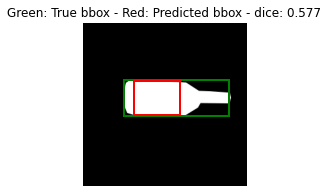

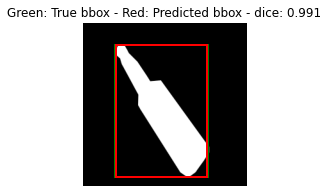

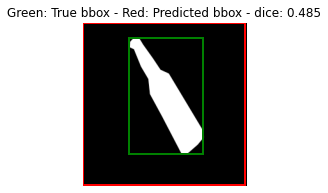

Average Jaccard Index: 0.64041682774831
---------  -----  -----  -----  -----  -----
Obj        de     di     ne     ni     TOTAL
tesoura    0.113  0.222  0.176  0.469  0.23
garrafa    0.774  0.442  0.393  0.717  0.567
chave      0.569  0.557  0.21   0.56   0.531
prato      0.786  0.709  0.651  0.759  0.737
livro      0.757  0.93   0.625  0.816  0.785
sapato     0.824  0.782  0.537  0.857  0.765
chinelo    0.901  0.809  0.627  0.702  0.738
celular    0.741  0.789  0.636  0.774  0.742
portacopo  0.203  0.472  0.512  0.448  0.438
caneca     0.72   0.871  0.572  0.763  0.757
TOTAL      0.664  0.69   0.502  0.676  0.64
---------  -----  -----  -----  -----  -----
---------  -----  -----  -----  -----
Obj        f1     f2     f3     TOTAL
tesoura    0.176  0.316  0.178  0.23
garrafa    0.809  0.471  0.481  0.567
chave      0.535  0.573  0.49   0.531
prato      0.627  0.877  0.683  0.737
livro      0.802  0.784  0.774  0.785
sapato     0.812  0.792  0.699  0.765
chinelo    0.856  0.794  0.56

In [36]:
avg_dice = 0
n_imgs = 0
dice_dict_box = {}
for key in groundTruthImagesDict.keys():
  image_gt = groundTruthImagesDict[key]
  image_seg = segment_watershed(originalGroundTruthImagesDict[key])
#   image_with_interior = fill_segmentation_interior(image_seg)
  dice_dict_box[key] = evaluate_bbox(image_gt, image_seg, 
                                            metric = "dice",
                                            plot_comparison = (n_imgs <3) )
  avg_dice += dice_dict_box[key] 
  n_imgs += 1
print(f"Average Jaccard Index: {avg_dice/n_imgs}")
print_metric_table(dice_dict_box)
print_metric_table_fundo(dice_dict_box)